# Exploratory Data Analysis (EDA) for Molecular Descriptor Dataset

**Author:** Rana Elladki  
**Date:** October 20, 2025  

---

## Table of Contents
1. [Introduction](#1-introduction)
2. [Importing Dependencies](#2-importing-dependencies)
3. [Feature Correlation Analysis](#3-feature-correlation-analysis)
4. [Outlier Filtering](#4-outlier-filtering)
5. [Log Transformation of Skewed Features](#5-log-transformation-of-skewed-features)
6. [Data Splitting for ML Modeling](#6-data-splitting-for-ml-modeling)
7. [Summary](#7-summary)

---

## 1. Introduction
Exploratory Data Analysis (EDA) is the first step when working with a large dataset, before training your machine learning models.  
This notebook:
- Identifies **important molecular descriptors** correlated with the target property (`RG2`).
- Removes **outliers** to enhance model stability.
- Applies **log transformations** to reduce skewness.
- Splits data into **train, validation, and test sets** for machine learning.

Let's import a small dataset to show the results from EDA. This sample dataset contains 100 molecules, to demo the EDA. The actual dataset is ~134,000 molecules, so the results might different. However, for the sake of efficiency, this notebook will just use the sample set, which is NOT sufficient to train an entire model in reality.  

In [15]:
import sys
sys.path.append("../src")

# import functions that we need to get a sample dataset

from parse_xyz import parse_xyz_folder
from multiprocessing import Pool, cpu_count
import extract_desc
import pandas as pd

In [16]:
data_dir = "../sample_data/"
df = parse_xyz_folder(data_dir, as_dataframe=True, check_cache=False)
# get small molecules only from dataset
mols_arr = extract_desc.get_small_molec(df)
# get atomic coordinates for molecules
coord_arr = extract_desc.get_atom_coords(df)

# build descriptor dict for all molecules

with Pool(processes=cpu_count()) as pool:
    all_desc = pool.map(extract_desc.process_molecule, zip(mols_arr, coord_arr))

# index it with SMILES
desc_df = pd.DataFrame(all_desc).set_index("SMILES")

Parsing all XYZ files in ../sample_data/ ...
Saving parsed data to ../sample_data/xyz_data.parquet ...


## 2. Importing Dependencies

In [21]:
# Importing dependencies

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import copy
from sklearn.model_selection import train_test_split

### Libraries:

- **pandas/numpy** -> Data manipulation and analysis  
- **seaborn/matplotlib** -> Statistical plotting and visual exploration  
- **sklearn** -> Training/validation/testing data splitting  


## 3. Feature Correlation Analysis

First, we start with a Pearson correlation coefficient analysis, to identify which discriptors most strongly correlate with the target property, the radius of gyration (RG2).

In [18]:
def pearson_correlation(df, outdir=None, target='RG2', top_count=20, draw=1):
    """
    Perform Pearson correlation coefficient analysis to identify descriptors
    that have the strongest relationship with the target variable (e.g., RG2).
    """
    # drop IDs because that is not a feature 
    df = df.drop(["ID"], axis=1)
    # get the correlation matrix using pearson correlation coefficient analysis
    corr_pearson = df.corr(method='pearson')
    # get the rg2 correlation column and remove rg2's correaltion with itself, because it is just 1
    rg2_corr = corr_pearson[target].drop(target).abs().sort_values(ascending=False)
    # check number of features available
    available_feats = len(rg2_corr)
    # if less features available than specified in top count, use all available features
    if top_count > available_feats:
        print(f"Not enough features for defaulting {top_count}. "
              f"Only {available_feats} available and were used.")
        top_count = available_feats
    # get top 20 features
    strong_corr = rg2_corr.index[:top_count]
    # reduced descriptor dataframe
    reduced_df = df[strong_corr.tolist() + [target]]
    # get a heat map
    if draw==1:
        if outdir is None:
           raise ValueError("draw=1 requires 'outdir' to be specified.")
        outfile = os.path.join(outdir,f"corr_heatmap_top_{top_count}_feats.png")
        plt.figure(figsize=(14,14))
        sns.heatmap(reduced_df.corr(), cmap="coolwarm", center=0, annot=True, fmt=".2f")
        plt.savefig(outfile, dpi=300)
        plt.close()
    # get a heat map
    # 3 LINES BELOW ARE ONLY INCLUDED IN NOTEBOOK TO SHOW PLOT. 
    plt.figure(figsize=(10,10))
    sns.heatmap(reduced_df.corr(), cmap="coolwarm", center=0, annot=True, fmt=".2f")
    plt.show()
    return reduced_df

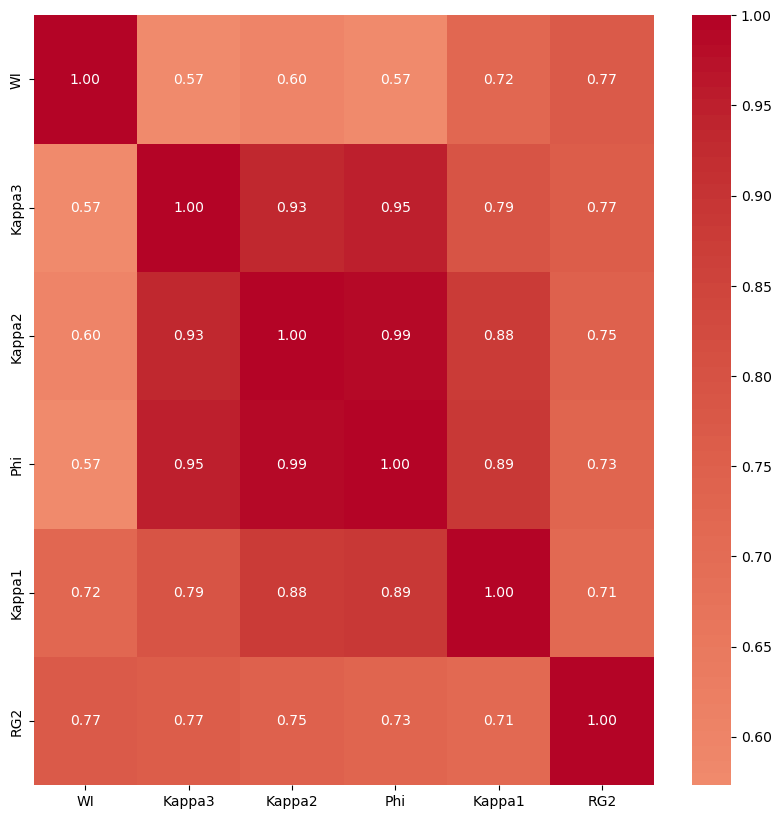

,WI,Kappa3,Kappa2,Phi,Kappa1,RG2
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,80.620000,1.111242,1.938705,1.365278,5.720195,4.273853
std,14.153402,1.146856,0.986910,0.999528,1.133608,1.083202
min,35.000000,0.123967,0.602563,0.261573,3.048034,2.127936
25%,75.750000,0.398234,1.219760,0.671592,4.962819,3.667385
50%,83.000000,0.809048,1.814721,1.196717,5.667271,4.053412
75%,88.250000,1.285515,2.261024,1.507364,6.240692,4.683428
max,114.000000,7.560000,5.692275,5.413986,8.670000,9.400589


In [19]:
# perform Pearson correlation coefficient analysis

reduced_df = pearson_correlation(df=desc_df, top_count=5, draw=0)
reduced_df.describe()

### Interpretation of Results:

- After running the analysis, a reduced dataframe containing only the descriptors with the highest correlation with RG2 is returned. 

- A **heatmap** is printed to provide overview of descriptor relationships.

- The last column shows us the relationship of the descriptors on the x axis in relationship with RG2. We can see that the top 5 factors exceed 0.7, which is indicative of a strong correlation with RG2. 

- To see how different factors are correlated with RG2, change the top_count to 10 or 20 to see how different descriptors are related to RG2. 


## 4. Outlier Filtering

Outliers can distort model training, so we want to understand the relationship of the features with the target property and filter out outliers, possibly skewing that relationship.

In [20]:
def filter_outliers(df, outdir=None, q_min=0.001, q_max=0.999, draw=1):
    """ 
    This function is inspired from Day13-inclass 
    
    Filter outliers based on percentile thresholds for each feature.
    """
    # histogram of data before filtering 
    if draw==1:
        if outdir is None:
           raise ValueError("draw=1 requires 'outdir' to be specified.")
        outfile = os.path.join(outdir,"hist_unfiltered.png") 
        df.hist(figsize=(10,10), bins=50)
        plt.tight_layout()  # make sure subplots don't overlap
        plt.savefig(outfile, dpi=300)
        plt.close()
    # 4 LINES BELOW ARE ONLY INCLUDED IN NOTEBOOK TO SHOW PLOT. 
    df.hist(figsize=(10,10), bins=50)
    plt.suptitle("Histogram Before Outlier Filtering", fontsize=16)
    plt.tight_layout()  # make sure subplots don't overlap
    plt.show()

    # define a percentile value range for features
    perc_range = pd.DataFrame([df.quantile(q=q_min, axis=0), df.quantile(q=q_max, axis=0)])
    
    for feat in df.columns[:-1]:
        # these are small molecules, so most will have NumRotatableBonds=0 which will end up getting excluded, so don't remove outliers because data correctly mostly zeros
        # include features that have values greater than or equal to bottom 0.1% of data
        df = df[df[feat] >= perc_range[feat].iloc[0,]]
        # include features that have values less than or equal to top 99% of data
        df = df[df[feat] <= perc_range[feat].iloc[1,]]
    
    if draw==1:
        if outdir is None:
           raise ValueError("draw=1 requires 'outdir' to be specified.")
        outfile = os.path.join(outdir,"hist_filtered.png")
        df.hist(figsize=(10,10), bins=50)
        plt.tight_layout()  # make sure subplots don't overlap
        plt.savefig(outfile, dpi=300)
        plt.close()
    # 4 LINES BELOW ARE ONLY INCLUDED IN NOTEBOOK TO SHOW PLOT.     
    df.hist(figsize=(10,10), bins=50)
    plt.suptitle("Histogram After Outlier Filtering", fontsize=16)
    plt.tight_layout()  # make sure subplots don't overlap
    plt.show()
    
    return df

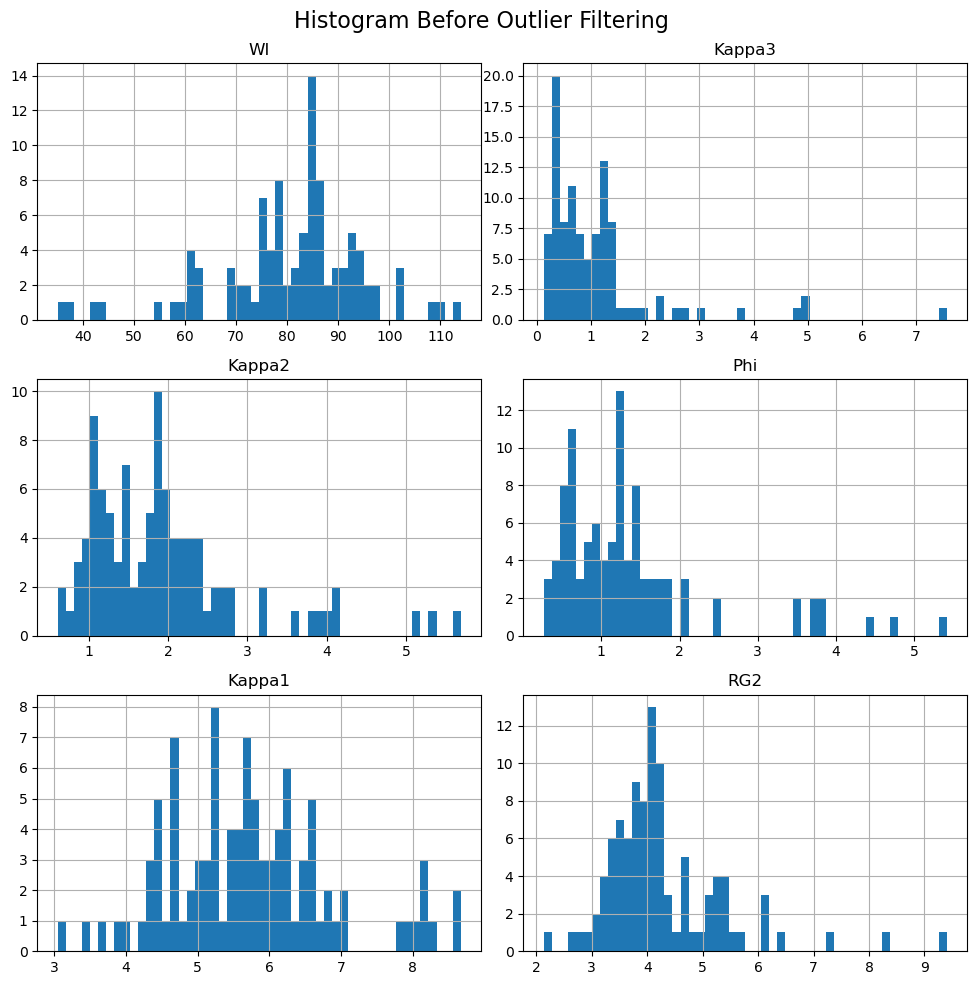

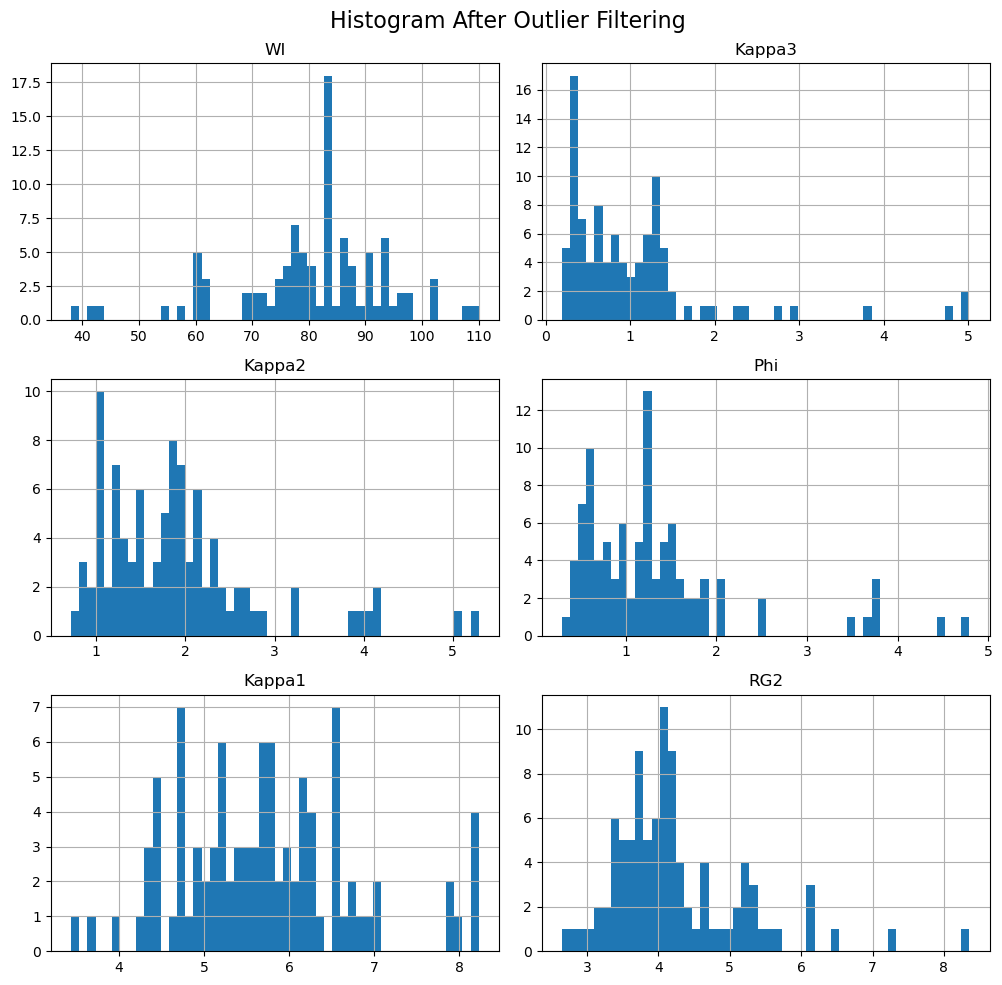

,WI,Kappa3,Kappa2,Phi,Kappa1,RG2
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,80.750000,1.048062,1.909195,1.323506,5.706610,4.245141
std,13.126911,0.940830,0.893628,0.890468,1.026028,0.934354
min,38.000000,0.190506,0.716867,0.295867,3.434259,2.647640
25%,76.000000,0.409622,1.233421,0.679529,5.015447,3.678679
50%,83.000000,0.809048,1.814721,1.196717,5.667271,4.053412
75%,88.000000,1.260840,2.188814,1.486705,6.223457,4.672838
max,110.000000,5.013838,5.289860,4.790262,8.230000,8.358477


In [22]:
fltrd_df = filter_outliers(df=copy.deepcopy(reduced_df), draw=0)
fltrd_df.describe()

### Interpretation of Results:

- After running the analysis, a reduced dataframe with the outliers removed is returned. We can see the from the count row that 4 data points were removed.  

- The **filter_outliers()** function shows two figures, one with histograms of the descriptors before filtering and another after filtering. 

- We may not see obvious differences in the small dataset, but we can take a look at descriptor kappa3 as an example. There is a data point at ~7.56, which seems much further than the average of 1.1 falling outside the 99.9-percentile range. Therefore, we can see in the filtered histograms, that this data point was removed. 

- Another important feature that histograms helps us visualize is skewed data. For example, looking at kappa3 or Phi, we can see that the data is heavily skewed to the right. Therefore, we need to take additional steps to adjust that skewness. 

## 5. Log Transformation of Skewed Features

Heavily skewed data can bias machine learning models. Therefore, we can apply a log2 transform to reduce the skewness, making the data follow more of a Gaussian distribution.

In [24]:
def log_transform(df, outdir=None, exclude=None, skew_thresh=1.0, draw=1):
    """Apply log2 transformation to columns with high skewness."""
    # calculate skewness for each column
    skewness = df[df.columns].skew()
    print("Calculated skewness of features")
    print(skewness)
    for col in df.columns:
        if exclude!=None and col in exclude:   
            continue
        if np.abs(skewness[col]) >= skew_thresh and (df[col] > 0).all():
            df[col] = np.log2(df[col])
    
    if draw == 1:
        if outdir is None:
           raise ValueError("draw=1 requires 'outdir' to be specified.")
        outfile = os.path.join(outdir, "hist_logged.png")
        df.hist(figsize=(10,10), bins=50)
        plt.tight_layout()  # make sure subplots don't overlap
        plt.savefig(outfile, dpi=300)
        plt.close()
    
    # 4 LINES BELOW ARE ONLY INCLUDED IN NOTEBOOK TO SHOW PLOT. 
    df.hist(figsize=(10,10), bins=50)
    plt.suptitle("Histogram After Log Transform", fontsize=16)
    plt.tight_layout()  # make sure subplots don't overlap
    plt.show()
    return df

Calculated skewness of features
WI       -0.811313
Kappa3    2.634513
Kappa2    1.613462
Phi       2.013870
Kappa1    0.527841
RG2       1.586418
dtype: float64


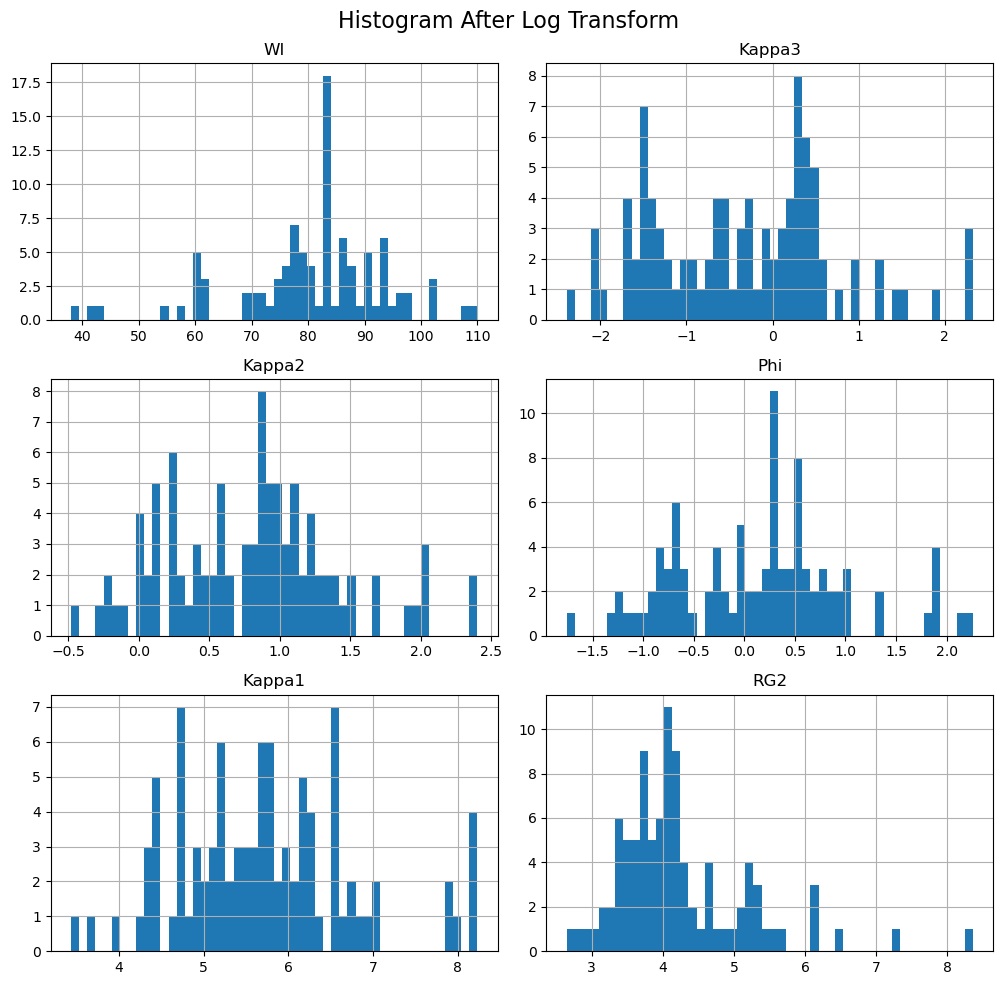

,WI,Kappa3,Kappa2,Phi,Kappa1,RG2
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,80.750000,-0.333270,0.800635,0.153189,5.706610,4.245141
std,13.126911,1.044703,0.607596,0.832790,1.026028,0.934354
min,38.000000,-2.392088,-0.480223,-1.756979,3.434259,2.647640
25%,76.000000,-1.287796,0.302655,-0.557423,5.015447,3.678679
50%,83.000000,-0.305704,0.859725,0.259083,5.667271,4.053412
75%,88.000000,0.334313,1.129903,0.572103,6.223457,4.672838
max,110.000000,2.325915,2.403230,2.260105,8.230000,8.358477


In [25]:
logged_df = log_transform(df=copy.deepcopy(fltrd_df), exclude="RG2", draw=0)
logged_df.describe()

### Interpretation of Results:

- After running the analysis, a dataframe with the skewed data logged is returned. 

- The **log_transform()** function shows the histograms after the data is logged. Compared to the previous histogram, the data looks more Gausian, rather than a heavy skew in one direction. 

- We can take a look at the mean of Phi and Kappa3 to see the difference before and after applying the log transform. 

    |Descriptor |Before| After|
    |-----------|------|------|
    |Kappa3| 1.048|-0.333|
    |Phi| 1.324 |0.153 |

We can see that there is a clear difference between the descritor means before and after the application of the transform. Once again, this shift is much more dramatic using the sampled dataset, as the number of data is limited. However, we would still expect to see this shift in mean when applying the log transform to the entire dataset. 

## 6. Data Splitting for ML Modeling

After performing EDA, we can split the data into training, validation, and testing datasets to train the machine learning models. To make sure that we are accurately evaluating our machine learning models, we will use the same sets for each model, for a more accurate comparison. 

The datasplit is as follows:
- The data is split into 80% training and validation and 20% testing. 
- The 80% is then split into 75% training and 25% validation.
- The original dataset is therefore split into 60% training, 20% validation, and 20% testing. 

In [26]:
def split_data(df, rand_state=42):
    """Split the dataset into training, validation, and test sets."""
    # drop RG2 because that is what we want to predict
    X = df.drop(["RG2"], axis=1)
    y = df["RG2"]

    # split into training/validation and test set (80:20)
    X_train_val, X_test, y_train_val, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
    # split training/validation set into separate training and validation sets (75:25)
    X_train, X_val, y_train, y_val = \
        train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=rand_state)
    
    data_split = (X_train, X_val, X_test, y_train, y_val, y_test)

    return data_split

In [27]:
data_split = split_data(logged_df)
print("Training dataset size:", len(data_split[0]))
print("Validation dataset size:", len(data_split[1]))
print("Testing dataset size:", len(data_split[2]))


Training dataset size: 57
Validation dataset size: 19
Testing dataset size: 20


## 7. Summary

This notebook guided the EDA process for molecular descriptor datasets:
1. **Correlation Analysis** — Feature reduction using Pearson correlation coefficient analysis.
2. **Outlier Filtering** — Removal of extreme values (outliers) for stable modeling.
3. **Log Transformations** — Normalization (Gaussian-like) of skewed distributions.
4. **Data Splitting** — Preparation for downstream machine learning.

All visualizations and processed data can now be used to train and evaluate predictive models of molecular properties.
